In [1]:
import ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.colors import ListedColormap
import math

df = pd.read_csv("Cleaned_DF.csv")

In [2]:
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [3]:
mask1 = (df['CryoSleep']==0)&(df['Age']>12.5)
features = ['Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Deck','Num','Side','route']
dz = df[mask1][features+["Transported"]]
dz.shape

(4447, 12)

MV 1: [-5.3163e-03  1.5682e-04  1.0700e-01 -1.6002e-01 -1.1772e-01  1.0652e-01
  9.5508e-02  5.1048e-02  2.4304e-02 -7.8162e-02 -3.3554e-02]

MV 2: [ 1.2183e-02 -3.5937e-04 -2.4522e-01  3.6670e-01  2.6977e-01 -2.4411e-01
 -2.1887e-01 -1.1698e-01 -5.5695e-02  1.7912e-01  7.6894e-02]

Собственные значения в порядке убывания:

72.73116159903168
4.45333431583576e-15
3.8102670217192735e-15
2.415513101848506e-15
2.199530759326407e-15
2.199530759326407e-15
1.5023955058289916e-15
1.5023955058289916e-15
2.0491235130982727e-16
2.0491235130982727e-16
0.0


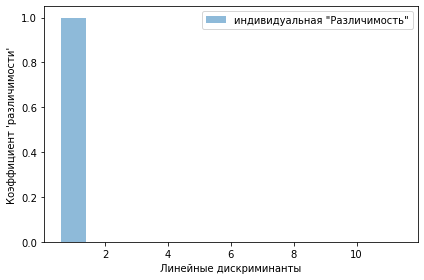

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y = dz["Transported"]
X = dz[features]
X_std = sc.fit_transform(X)

np.set_printoptions(precision = 4)
mean_vecs = []
labels = [-1.0,1.0]
for label in range(1,len(labels)+1):
    mean_vecs.append(np.mean(X_std[y == labels[label-1]],axis = 0))
    print('MV %s: %s\n'%(label,mean_vecs[label-1]))

d = len(features)
S_W = np.zeros((d,d))
for label , mv in zip(labels , mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_std[y == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
#print ('Матрица раcсеяния внутри классов: %sx%s'%(S_W.shape[0], S_W.shape[1]))

S_W = np.zeros((d,d))
for label,mv in zip(labels, mean_vecs):
    class_scatter = np.cov(X_std[y==label].T)
    S_W += class_scatter
#print('Масштабированная матрица рассеяния внутри классов: %sx%s' % (S_W.shape[0], S_W.shape[1]) )

mean_overall = np.mean(X_std, axis= 0)
S_B = np.zeros((d,d))
for i , mean_vec in enumerate(mean_vecs):
    n = X_std[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B +=n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
#print('Матрица рассеяния между классами: %sx%s'%(S_B.shape[0],S_B.shape[1]))

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs=sorted(eigen_pairs, key = lambda k: k[0], reverse = True)

print('Собственные значения в порядке убывания:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted (eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)
size = len(features)+1
plt.bar(range(1,size),discr, alpha = 0.5, align = 'center',label = 'индивидуальная "Различимость"')
plt.ylabel("Коэффициент 'различимости'")
plt.xlabel('Линейные дискриминанты')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [5]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real))
print('Матрица W:\n',w)

Матрица W:
 [[ 1.9009e-02  1.2147e-02]
 [-3.4568e-02 -6.8738e-01]
 [-4.0788e-01 -3.4099e-01]
 [ 3.9736e-01 -1.3029e-01]
 [ 2.6689e-01 -2.2296e-01]
 [-5.2272e-01 -1.7862e-01]
 [-4.9192e-01 -3.2364e-01]
 [-1.8578e-01  1.1403e-04]
 [-1.1407e-03  3.4395e-02]
 [ 2.3044e-01 -4.1813e-01]
 [-1.0751e-02 -1.7815e-01]]


<function matplotlib.pyplot.show(close=None, block=None)>

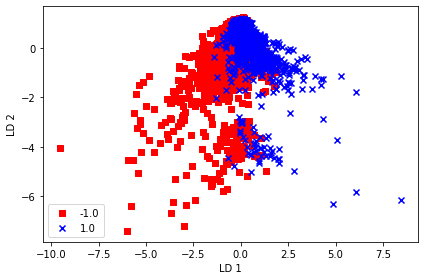

In [6]:
X_lda = X_std.dot(w)

colors = ['r','b']
markers = ['s','x']
for l,c,m in zip(np.unique(y),colors, markers):
    plt.scatter(X_lda[y == l, 0],X_lda[y == l, 1],c = c, label = l, marker = m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show

0.8594558129075781

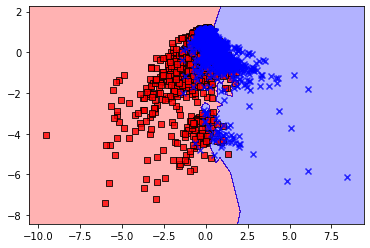

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3, p=2, metric = "minkowski")
ppn_test = knn.fit(X_lda,y)
ds.plot_decision_regions(X_lda,y,classifier = ppn_test,resolution = 0.01)
knn.score(X_lda,y)

In [8]:
mask2 = (df['CryoSleep']==1)|(df['Age']<=12.5)
df_rest = df[mask2]
df_rest.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,3227.000000,3227.000000,3227.000000,3227.0,3227.0,3227.0,3227.0,3227.0,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000
mean,0.888131,24.850635,0.006508,0.0,0.0,0.0,0.0,0.0,0.606446,5.464208,589.664704,1.519058,4.223737
std,0.315254,15.956213,0.080419,0.0,0.0,0.0,0.0,0.0,0.795248,1.954902,488.612792,0.499714,2.410741
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,14.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,169.500000,1.000000,2.000000
50%,1.000000,24.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,6.000000,445.000000,2.000000,4.000000
75%,1.000000,35.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,974.000000,2.000000,7.000000
max,1.000000,78.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1888.000000,2.000000,9.000000


In [9]:
df_rest.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


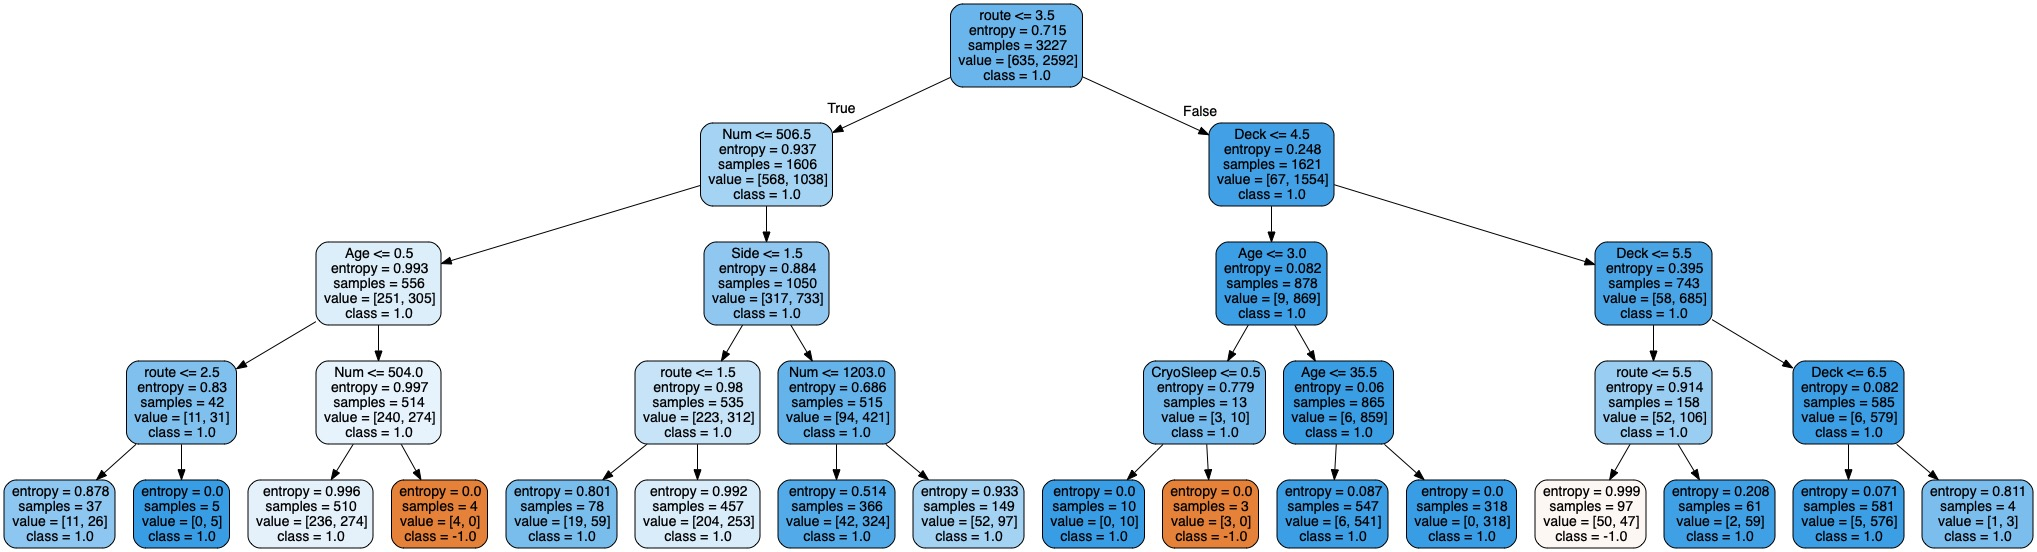

test size:  3227 , total errors in test: 19.37%
index = predicted, columns = factual, in %:
         -1        1
-1  1.76635  1.45646
 1  17.9114  78.8658


In [10]:
features = ['CryoSleep','Age','VIP','Deck','Num','Side','route']
tree = ds.divide_frame(dataf = df_rest,columns = features,teacher_column = "Transported",classifier = 'Tree', criterion_tree = "entropy", depth =4, random_state_sample = 5,random_state_ppn = 2, fraction = 1)

In [11]:
pd.value_counts(df_rest[df_rest["route"]>3.5]["Transported"])

 1.0    1554
-1.0      67
Name: Transported, dtype: int64

if "route">3.5 and ('CryoSleep'==1 or 'Age'<=12.5) ==> assign 1

In [12]:
mask3 = ((df['CryoSleep']==1)|(df['Age']<=12.5))&(df['route']<=3.5)
df_rest2 = df[mask3]

In [13]:
df_rest2.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,1606.000000,1606.000000,1606.0,1606.0,1606.0,1606.0,1606.0,1606.0,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000
mean,0.839352,20.279577,0.0,0.0,0.0,0.0,0.0,0.0,0.292653,6.947073,734.965131,1.504359,2.058531
std,0.367320,15.252832,0.0,0.0,0.0,0.0,0.0,0.0,0.956517,0.340881,442.836016,0.500137,0.625770
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,7.000000,342.500000,1.000000,2.000000
50%,1.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,729.500000,2.000000,2.000000
75%,1.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1092.000000,2.000000,2.000000
max,1.000000,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1808.000000,2.000000,3.000000


In [14]:
df_rest2.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


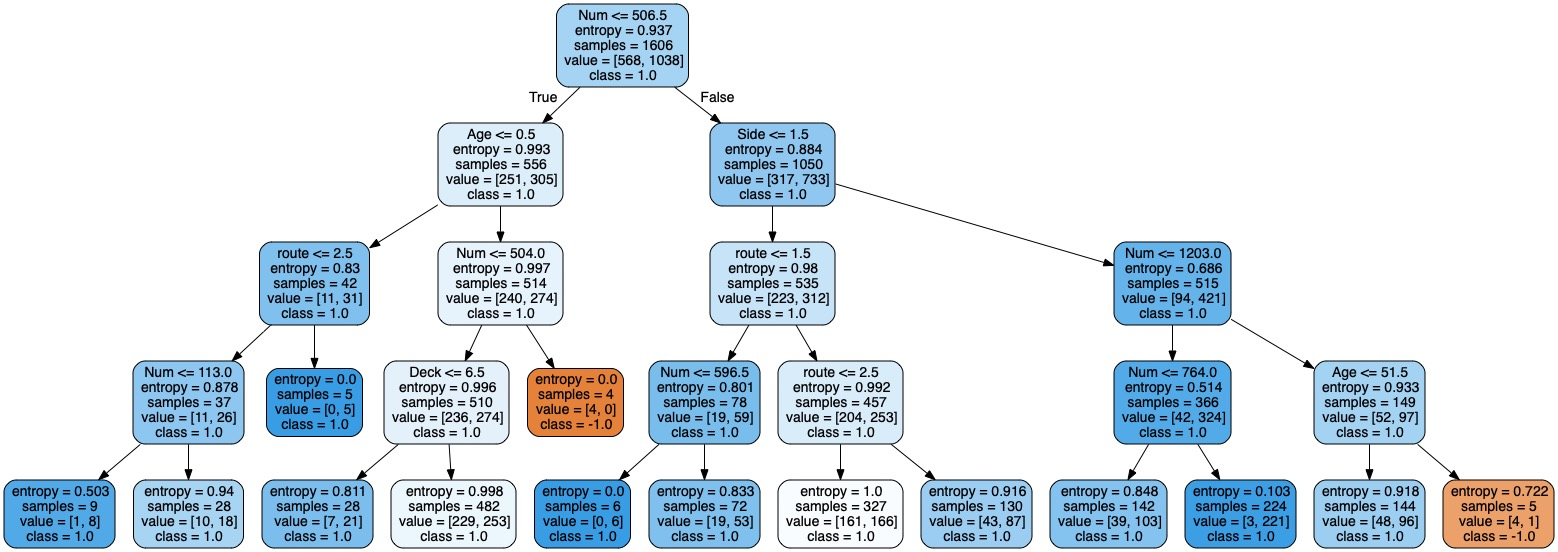

test size:  1606 , total errors in test: 34.93%
index = predicted, columns = factual, in %:
          -1          1
-1  0.498132  0.0622665
 1   34.8692    64.5704


In [15]:
features = ['CryoSleep','Age','Deck','Num','Side','route']
tree = ds.divide_frame(dataf = df_rest2,columns = features,teacher_column = "Transported",classifier = 'Tree', criterion_tree = "entropy", depth =4, random_state_sample = 5,random_state_ppn = 2, fraction = 1)

Somth happend in one part of the Spaceship. We can also remove (764 < Num <= 1203)&(Side == 2)  ==> assign y = 1.0
3 out of 224 are false

In [16]:
mask_disaster = (df['Num']>764)&(df['Num']<=1203)&(df['Side']==2)
print(pd.value_counts(df_rest2[mask_disaster]["Transported"]))

 1.0    221
-1.0      3
Name: Transported, dtype: int64


<ipython-input-16-7e8c21659880>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pd.value_counts(df_rest2[mask_disaster]["Transported"]))


In [17]:
mask4 = mask3&(~mask_disaster)
df_final =df[mask4]
df_final.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,1382.000000,1382.000000,1382.0,1382.0,1382.0,1382.0,1382.0,1382.0,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.835022,20.203329,0.0,0.0,0.0,0.0,0.0,0.0,0.182344,6.942113,696.259768,1.424023,2.069465
std,0.371295,15.208754,0.0,0.0,0.0,0.0,0.0,0.0,0.983591,0.362397,463.645249,0.494373,0.624929
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,7.000000,288.250000,1.000000,2.000000
50%,1.000000,18.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,630.000000,1.000000,2.000000
75%,1.000000,28.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1126.500000,2.000000,2.000000
max,1.000000,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1808.000000,2.000000,3.000000


In [18]:
df_final.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
df_final.shape

(1382, 7)

In [20]:
pd.value_counts(df_final["Transported"])

 1.0    817
-1.0    565
Name: Transported, dtype: int64

In [21]:
dz = df_final[df_final["Age"]>12.5]

In [22]:
dz.drop("CryoSleep", inplace = True, axis = 1)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
dz.shape

(924, 6)

In [37]:
dz

,Age,Transported,Deck,Num,Side,route
7,28.0,1.0,7.0,0.0,2.0,2.0
20,49.0,-1.0,5.0,0.0,2.0,1.0
21,29.0,-1.0,5.0,0.0,2.0,1.0
37,30.0,-1.0,7.0,1.0,1.0,1.0
38,17.0,1.0,7.0,2.0,1.0,2.0
...,...,...,...,...,...,...
7657,22.0,-1.0,7.0,1504.0,1.0,3.0
7661,31.0,1.0,7.0,1505.0,1.0,2.0
7662,33.0,1.0,7.0,1497.0,2.0,1.0
7665,23.0,1.0,7.0,1508.0,1.0,2.0


In [38]:
pd.value_counts(dz["Deck"])

7.0    898
6.0     14
5.0      9
2.0      1
1.0      1
3.0      1
Name: Deck, dtype: int64

In [39]:
pd.value_counts(dz["Side"])

1.0    540
2.0    384
Name: Side, dtype: int64

In [40]:
pd.value_counts(dz["route"])

2.0    529
3.0    272
1.0    123
Name: route, dtype: int64

In [41]:
dz.drop("Deck",axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [42]:
features = ['Age','Num','Side','route']
y = dz["Transported"]
X = dz[features]
X_std = sc.fit_transform(X)

np.set_printoptions(precision = 4)
mean_vecs = []
labels = [-1.0,1.0]
for label in range(1,len(labels)+1):
    mean_vecs.append(np.mean(X_std[y == labels[label-1]],axis = 0))
    print('MV %s: %s\n'%(label,mean_vecs[label-1]))

d = len(features)
S_W = np.zeros((d,d))
for label , mv in zip(labels , mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_std[y == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print ('Матрица раcсеяния внутри классов: %sx%s'%(S_W.shape[0], S_W.shape[1]))
print(S_W)

S_W = np.zeros((d,d))
for label,mv in zip(labels, mean_vecs):
    class_scatter = np.cov(X_std[y==label].T)
    S_W += class_scatter
print('Масштабированная матрица рассеяния внутри классов: %sx%s' % (S_W.shape[0], S_W.shape[1]) )
print(S_W)

MV 1: [ 0.1316 -0.0484 -0.0225  0.0558]

MV 2: [-0.0825  0.0304  0.0141 -0.035 ]

Матрица раcсеяния внутри классов: 4x4
[[ 913.9776  -53.0584  -18.4614  -46.3377]
 [ -53.0584  922.6413 -146.938    14.7223]
 [ -18.4614 -146.938   923.7067  -72.6779]
 [ -46.3377   14.7223  -72.6779  922.195 ]]
Масштабированная матрица рассеяния внутри классов: 4x4
[[ 2.0242 -0.0984 -0.0445 -0.1056]
 [-0.0984  2.0276 -0.3521  0.0412]
 [-0.0445 -0.3521  2.001  -0.1326]
 [-0.1056  0.0412 -0.1326  1.9366]]


Матрица рассеяния между классами: 4x4
Собственные значения в порядке убывания:

6.689110764243028
2.220446049250313e-16
2.723777570757685e-17
2.723777570757685e-17


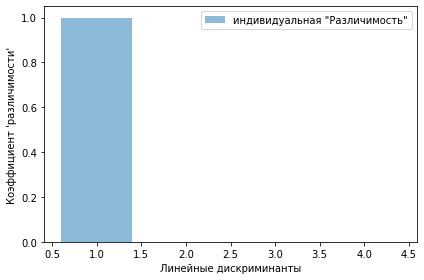

In [43]:
mean_overall = np.mean(X_std, axis= 0)
S_B = np.zeros((d,d))
for i , mean_vec in enumerate(mean_vecs):
    n = X_std[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B +=n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Матрица рассеяния между классами: %sx%s'%(S_B.shape[0],S_B.shape[1]))

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs=sorted(eigen_pairs, key = lambda k: k[0], reverse = True)

print('Собственные значения в порядке убывания:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted (eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)
size = len(features)+1
plt.bar(range(1,size),discr, alpha = 0.5, align = 'center',label = 'индивидуальная "Различимость"')
plt.ylabel("Коэффициент 'различимости'")
plt.xlabel('Линейные дискриминанты')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

seem like there are only one non-zero value for each of two classes - Transported = 0 and 1, i.e. only 2 variables are not correlating only i.e. there are 2x2 matrices

In [44]:
LDA_matrix = np.linalg.inv(S_W).dot(S_B)

In [45]:
np.linalg.det(LDA_matrix)

-1.8562341294769885e-49

let's take vectos and see what matrices will be non-zero

In [52]:
for i in range (0,4):
    print("vector",i,":\n ",eigen_pairs[i][1][:,np.newaxis].real)
    print("lambda",i,":", eigen_pairs[i][0]) 
    transfomed = LDA_matrix.dot(eigen_pairs[i][1][:,np.newaxis].real)
    print("Ax:\n",transfomed,"\n")

vector 0 :
  [[ 0.8443]
 [-0.303 ]
 [-0.1525]
 [ 0.4149]]
lambda 0 : 6.689110764243028
Ax:
 [[ 5.6473]
 [-2.0266]
 [-1.0203]
 [ 2.7756]] 

vector 1 :
  [[-0.5052]
 [-0.4879]
 [-0.2456]
 [ 0.6682]]
lambda 1 : 2.220446049250313e-16
Ax:
 [[ 8.8818e-16]
 [ 0.0000e+00]
 [-1.1102e-16]
 [ 1.1102e-16]] 

vector 2 :
  [[ 0.3054]
 [ 0.7538]
 [ 0.025 ]
 [-0.0556]]
lambda 2 : 2.723777570757685e-17
Ax:
 [[-3.0531e-16]
 [ 2.7756e-17]
 [ 4.5103e-17]
 [-5.5511e-17]] 

vector 3 :
  [[ 0.3054]
 [ 0.7538]
 [ 0.025 ]
 [-0.0556]]
lambda 3 : 2.723777570757685e-17
Ax:
 [[-3.0531e-16]
 [ 2.7756e-17]
 [ 4.5103e-17]
 [-5.5511e-17]] 



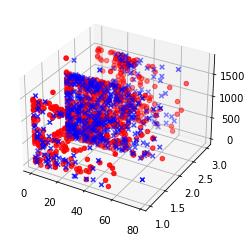

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = "3d")
df_final_transported = df_final[df_final["Transported"]==1.0]
df_final_left = df_final[df_final["Transported"]==-1.0]
ax.scatter(df_final_transported["Age"],df_final_transported["route"],df_final_transported["Num"],c = 'r',marker ='o')
ax.scatter(df_final_left["Age"],df_final_left["route"],df_final_left["Num"],c = 'b',marker ='x')
plt.show()

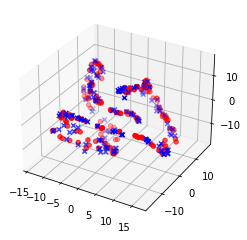

In [30]:
from sklearn.manifold import TSNE
X = df_final[features]
tsne = TSNE(n_components = 3,perplexity =20)
data_3d = pd.DataFrame(tsne.fit_transform(X))
data_3d["Transported"] = df_final["Transported"]

fig = plt.figure()
ax = fig.add_subplot(111,projection = "3d")
df_tsne_transported = data_3d[data_3d["Transported"]==1.0]
df_tsne_left = data_3d[data_3d["Transported"]==-1.0]
ax.scatter(df_tsne_transported[0],df_tsne_transported[1],df_tsne_transported[2],c = 'r',marker ='o')
ax.scatter(df_tsne_left[0],df_tsne_left[1],df_tsne_left[2],c = 'b',marker ='x')
plt.show()

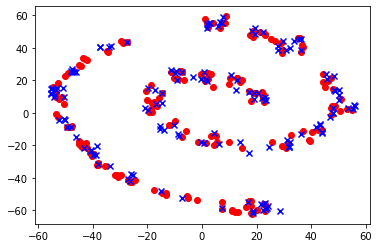

In [31]:
from sklearn.manifold import TSNE
X = df_final[features]
tsne = TSNE(n_components = 2,perplexity =20, random_state = 1)
result = tsne.fit_transform(X)
data_2d = df_final
data_2d = pd.DataFrame(result)
data_2d["Transported"] = df_final["Transported"]

fig = plt.figure()
ax = fig.add_subplot(111)
df_tsne_transported = data_2d[data_2d["Transported"]==1.0]
df_tsne_left = data_2d[data_2d["Transported"]==-1.0]
ax.scatter(df_tsne_transported[0],df_tsne_transported[1],c = 'r',marker ='o')
ax.scatter(df_tsne_left[0],df_tsne_left[1],c = 'b',marker ='x')
plt.show()

In [32]:
data_2d

,0,1,Transported
0,19.443825,6.047093,NaN
1,23.635042,7.090943,NaN
2,23.363791,6.825815,NaN
3,16.925367,6.058530,NaN
4,19.209520,6.009871,NaN
...,...,...,...
1377,23.886658,-58.574085,-1.0
1378,24.121506,-57.380840,-1.0
1379,23.439318,-56.594463,NaN
1380,24.290936,-58.504265,NaN


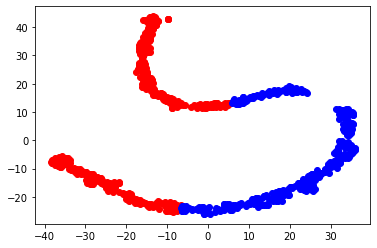

In [33]:
from sklearn.manifold import TSNE
look_for = df_final[df_final["Transported"]==1.0]
X = look_for[features]

tsne = TSNE(n_components = 2,perplexity =30, random_state = 2)
data_2d = pd.DataFrame(tsne.fit_transform(X))

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2,random_state=2)
clusters = (kmeans.fit(data_2d)).labels_

data_2d[2] = clusters
data_2d.index = look_for.index

data_2d_0 = data_2d[data_2d[2] == 0]
data_2d_1 = data_2d[data_2d[2] == 1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data_2d_0[0],data_2d_0[1],c = 'r',marker ='o')
ax.scatter(data_2d_1[0],data_2d_1[1],c = 'b',marker ='o')
plt.show()

In [34]:
data_2d

,0,1,2
7,-37.339920,-6.265743,0
17,-38.524075,-7.634624,0
22,-38.155380,-7.120480,0
38,-37.802650,-6.877174,0
41,-38.228115,-7.536248,0
...,...,...,...
7653,-13.070502,42.638020,0
7655,-13.717278,43.155327,0
7661,-13.409020,43.847168,0
7662,-13.770438,43.649597,0


In [35]:
df_final["clusters"] = data_2d[2]
df_final["clusters"]  = np.where(np.NaN, -1.0, df_final["clusters"])

<ipython-input-35-557887007274>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["clusters"] = data_2d[2]
<ipython-input-35-557887007274>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["clusters"]  = np.where(np.NaN, -1.0, df_final["clusters"])


In [36]:
df_final

,CryoSleep,Age,Transported,Deck,Num,Side,route,clusters
7,1.0,28.0,1.0,7.0,0.0,2.0,2.0,-1.0
17,0.0,0.0,1.0,7.0,0.0,1.0,2.0,-1.0
19,1.0,1.0,-1.0,5.0,0.0,2.0,2.0,-1.0
20,1.0,49.0,-1.0,5.0,0.0,2.0,1.0,-1.0
21,1.0,29.0,-1.0,5.0,0.0,2.0,1.0,-1.0
...,...,...,...,...,...,...,...,...
7657,1.0,22.0,-1.0,7.0,1504.0,1.0,3.0,-1.0
7661,1.0,31.0,1.0,7.0,1505.0,1.0,2.0,-1.0
7662,1.0,33.0,1.0,7.0,1497.0,2.0,1.0,-1.0
7665,1.0,23.0,1.0,7.0,1508.0,1.0,2.0,-1.0
